<a href="https://colab.research.google.com/github/Daniel-T-Henriques/CIFAR10-image-classifier/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [103]:
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

import torchvision
import torchvision.transforms as transf

from seaborn import heatmap as heatmap
from matplotlib import pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
)

transform = transf.Compose([transf.ToTensor(), transf.Normalize((0.5),(0.5))])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", transform=transform, train=True, download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", transform=transform, train=False, download=True
)

Files already downloaded and verified
Files already downloaded and verified


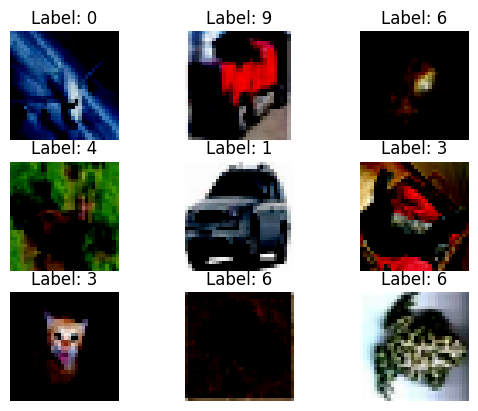

In [104]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=20, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=20, shuffle=False
)

examples = iter(train_loader)
images, labels = next(examples)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.show()

dicionary = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

### Criando a rede neural

In [105]:
class NeuralNet(nn.Module): #NN Herda nn_Module
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten() #Achatando imagem

        # Neurônio 1: 32*32*3 pixels de entrada (canal RGB), 128 saídas
        self.fc1 = nn.Linear(32*32*3, 512)

        # Neurônio 2: 510 entradas, 128 px de saída
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)

        # Neurônio 3: 128 px de entrada, classif. em 10 tipos (0-9)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [106]:
model = NeuralNet()
model = model.to("cuda")

# Função de perda e otimizador
criterium = nn.CrossEntropyLoss() #Entropia cruzada
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Treinamento
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Zerar os gradientes
        optimizer.zero_grad()

        # Passar pelo modelo
        outputs = model(images.to("cuda"))

        # Calcular a perda
        loss = criterium(outputs, labels.to("cuda"))

        loss.backward()

        # Atualizar os pesos
        optimizer.step()

    print((f"Epoch: {epoch+1}/{num_epochs}\nLoss: {loss.item():.5f}\n"))

Epoch: 1/10
Loss: 2.45600

Epoch: 2/10
Loss: 2.27497

Epoch: 3/10
Loss: 2.07711

Epoch: 4/10
Loss: 1.46272

Epoch: 5/10
Loss: 2.18978

Epoch: 6/10
Loss: 2.01545



KeyboardInterrupt: 

In [ ]:
print(torch.device("cuda"))

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to("cuda"))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.8f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()